In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *
from dask import compute, delayed

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=6, walltime='06:00:00')
cluster = PBSCluster(cores=6, processes=6,  walltime='04:00:00')
w = cluster.scale(6*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.24:44236 Dashboard: http://10.135.39.24:8787/status,Cluster Workers: 60 Cores: 60 Memory: 1.00 TB


__________

# Read one face

In [77]:
time_length = 358
face = 1
dij=4

In [78]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

du_dt = xr.open_zarr(E_dir+'du_dt_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
dudt = du_dt.du_dt

f_v = xr.open_zarr(E_dir+'fv_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
fv = f_v.fv

zeta_v = xr.open_zarr(E_dir+'zeta_v_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
zeta_v = zeta_v.zeta_v

dKEdx = xr.open_zarr(E_dir+'dKE_dx_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
dKE_dx = dKEdx.dKE_dx

detadx = xr.open_zarr(E_dir+'deta_dx_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
deta_dx = detadx.deta_dx

residuals_u = xr.open_zarr(E_dir+'residuals_u_f%02d.zarr'%(face)).isel(time=slice(0, time_length))
residuals_u = residuals_u.residuals_u

In [79]:
# read data
ds = xr.merge([dudt,fv, zeta_v,dKE_dx, deta_dx, residuals_u])

# define (real) time
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2011,11,23,8)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(time_length))
ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (i: 1080, j: 1080, time: 358)
Coordinates:
    CS           (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    Depth        (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    SN           (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    XC           (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    YC           (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
    face         int64 1
    hFacC        (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    rA           (j, i) float32 dask.array<chunksize=(1080, 1080), meta=np.ndarray>
  * time         (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
    dtime        (time) datetime64[ns] dask.array<chunksize=(358,), m

In [80]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
lice = ice.isel(face=1)
lice

<xarray.DataArray 'AREA' (j: 1080, i: 1080)>
dask.array<getitem, shape=(1080, 1080), dtype=float64, chunksize=(1080, 1080), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

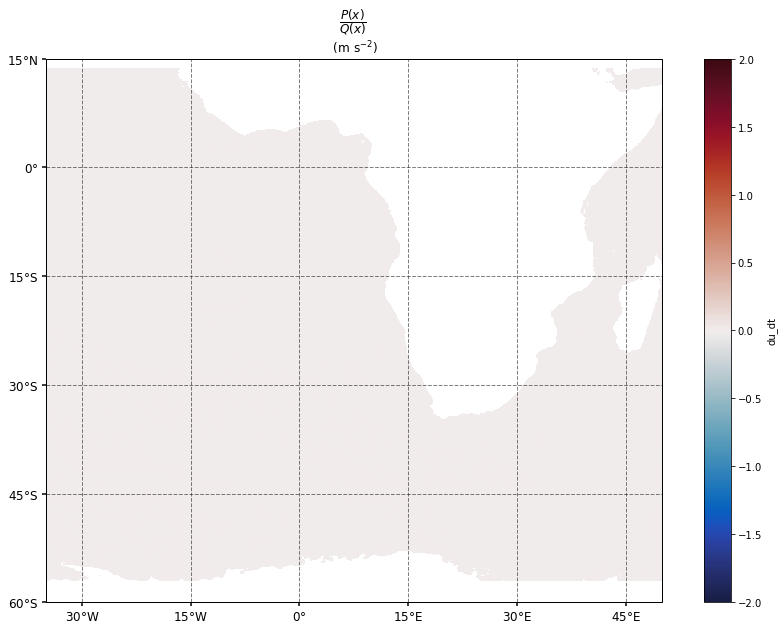

In [94]:
eta = ds['du_dt'].isel(time=1).where(lice>0)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2,cmap=cm.balance)
ax.grid(linewidth=1 , color='k', alpha=0.5, linestyle='--')
ax.set_xlim(-35., 50.)
ax.set_xticks([-30, -15, 0, 15, 30, 45])
ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
ax.set_ylim(-60., 15.)
ax.set_yticks([-60, -45, -30, -15, 0, 15])
ax.set_yticklabels(['$60\degree$S','$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
ax.tick_params(direction='out', length=4, width=1.5)
ax.set_title('$\dfrac{P(x)}{Q(x)}$ \n (m s$^{-2}$)')   
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

# Movies

In [97]:
font_size = 12
linewidith = 0.5

def plot_scalar(v1, v2, v3, v4, v5, v6, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(10,10), cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        #ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
        #colmap = _get_cmap(v1, cmap)
        try:
            
            ## subplot 231
            ax = fig.add_subplot(231, projection=ccrs.PlateCarree())
            im = v1.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            #gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            #gl.xlabels_top = False
            #gl.ylabels_right = False
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[0],fontsize=font_size) 
            #cb.set_label(label=label[0], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=4, width=1.5)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)

            ## subplot 232
            ax = fig.add_subplot(232, projection=ccrs.PlateCarree())
            im = v2.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[1],fontsize=font_size)                        
            #cb.set_label(label=label[1], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=6, width=2)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
       
            ## subplot 233
            ax = fig.add_subplot(233, projection=ccrs.PlateCarree())
            im = v3.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[2],fontsize=font_size)                        
            #cb.set_label(label=label[2], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=6, width=2)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            
            ## subplot 234
            ax = fig.add_subplot(234, projection=ccrs.PlateCarree())
            im = v4.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[3],fontsize=font_size)    
            #cb.set_label(label=label[3], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=6, width=2)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            
            ## subplot 235
            ax = fig.add_subplot(235, projection=ccrs.PlateCarree())
            im = v5.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[4],fontsize=font_size)    
            #cb.set_label(label=label[4], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=6, width=2)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            
            ## subplot 236
            ax = fig.add_subplot(236, projection=ccrs.PlateCarree())
            im = v6.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                   x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            cb=fig.colorbar(im)
            ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[5],fontsize=font_size)    
            #cb.set_label(label=label[5], fontsize=font_size)
            ax.set_xlim(-35., 50.)
            ax.set_xticks([-30, -15, 0, 15, 30, 45])
            ax.set_xticklabels(['$30\degree$W','$15\degree$W','$0\degree$','$15\degree$E','$30\degree$E','$45\degree$E'])
            ax.set_ylim(-55., 15.)
            ax.set_yticks([-45, -30, -15, 0, 15])
            ax.set_yticklabels(['$45\degree$S','$30\degree$S','$15\degree$S','$0\degree$','$15\degree$N'])
            ax.tick_params(direction='out', length=6, width=2)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
                           
        except:
            pass
            
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [98]:
vmin, vmax = -4e-5, 4e-5
lds = ds

def process(ds, i, overwrite=True):    
    
    du_dt = ds['du_dt'].where(lice>0)
    fv = -1*ds['fv'].where(lice>0)
    zeta_v = -1*ds['zeta_v'].where(lice>0)
    dKE_dx = ds['dKE_dx'].where(lice>0)
    deta_dx = ds['deta_dx'].where(lice>0)
    residual_u = ds['residuals_u'].where(lice>0)
    
    #mtime = ds['time'].values/86400
    mtime = time_day[i]
    figname = '/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/M_Movies/Mo_f%02d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        
        #title = ['%s' %mtime, '%s' %mtime, '%s' %mtime, '%s' %mtime, '%s' %mtime, '%s' %mtime]

        title = ['$\partial u/\partial t$ (m s$^{-2}$)', '%s \n $-\zeta v$ (m s$^{-2}$)' %mtime, '$\partial KE/\partial x$ (m s$^{-2}$)', 
                 '$-fv$ (m s$^{-2}$)', '$g\partial \eta/\partial x$ (m s$^{-2}$)', '$R_u$ (m s$^{-2}$)']
        
        
        #label = ['$\\frac{\partial u}{\partial t}$ (m s$^{-2}$)', '$-\zeta v$ (m s$^{-2}$)', '$\\frac{\partial KE}{\partial x}$ (m s$^{-2}$)', 
        #         '$-fv$ (m s$^{-2}$)', '$g\\frac{\partial \eta}{\partial x}$ (m s$^{-2}$)', '$R_u$ (m s$^{-2}$)']
            
        plot_scalar(du_dt, zeta_v, dKE_dx, fv, deta_dx, residual_u, colorbar=False, title=title, label=None, savefig=figname, vmin=vmin, vmax=vmax, offline=False, figsize=(24,10), cmap=cm.balance)
        #
        m = float(du_dt.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
#I = range(0,10)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

range(0, 358)


In [99]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 1min, sys: 14.3 s, total: 1min 14s
Wall time: 2min 9s


# Global

In [5]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/daily/'

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
du_dt = xr.concat([xr.open_zarr(E_dir+'du_dt_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_v = xr.concat([xr.open_zarr(E_dir+'fv_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
zeta_v = xr.concat([xr.open_zarr(E_dir+'zeta_v_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
dKEdx = xr.concat([xr.open_zarr(E_dir+'dKE_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
detadx = xr.concat([xr.open_zarr(E_dir+'deta_dx_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals_u = xr.concat([xr.open_zarr(E_dir+'residuals_u_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')

dudt = du_dt.du_dt
fv = f_v.fv
zeta_v = zeta_v.zeta_v
dKE_dx = dKEdx.dKE_dx
deta_dx = detadx.deta_dx
residuals_u = residuals_u.residuals_u

In [6]:
time_length = 358
dij=4

ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij))

# define (real) time
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2011,11,23,8)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(time_length))

In [7]:
# read data
ds = xr.merge([dudt,fv, zeta_v,dKE_dx, deta_dx, residuals_u])
ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (face: 13, i: 1080, j: 1080, time: 358)
Coordinates:
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * time         (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
    CS           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC        (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA           (face, j, i) float32 dask.array<chunks

In [8]:
font_size = 20

def plot_pretty_6(v1, v2, v3, v4, v5, v6, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                  offline=False, figsize=(20,12), cmmap='thermal', ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        cmap = getattr(cm, cmmap)
        
        # 1
        ax = fig.add_subplot(321, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v1.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[0], fontsize=font_size)   
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[0],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        # 2
        ax = fig.add_subplot(322, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v2.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[1], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        #ax.set_title('%s \n $-\zeta v \: (m\, s^{-2})$'%mtime, fontsize=font_size) 
        ax.set_title(title[1],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)        

        # 3
        ax = fig.add_subplot(323, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v3.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[2], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[2],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)                

        # 4
        ax = fig.add_subplot(324, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v4.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[3], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[3],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)     

        # 5
        ax = fig.add_subplot(325, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v5.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[4], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title(title[4],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)     

        # 6
        ax = fig.add_subplot(326, projection=ccrs.PlateCarree(central_longitude=180))
        gen = [0,1,2,3,4,5,7,8,9,10,11,12]
        for face in gen:
            vplt = v6.isel(face=face)
            im = vplt.plot.pcolormesh(ax=ax,                   
                            transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                            x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
        cb = plt.colorbar(im, ax=ax)
        cb.set_label(label=label[5], fontsize=font_size)            
        cb.ax.tick_params(labelsize=font_size) 
        ax.set_title(title[5],fontsize=font_size) 
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)     
        
        #if title is not None:
        #    ax.set_title(title, size=font_size)
        #if label is not None:
        #    cb.set_label(label=label, size=font_size)     #
            
        if savefig is not None:
            fig.savefig(savefig, dpi=100)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

In [17]:
vmin, vmax = -4e-5, 4e-5
lds = ds

def process(ds, i, overwrite=True):    
    
    du_dt = ds['du_dt'].where(ice>0)
    hadv = -1*ds['zeta_v'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0) + ds['dKE_dx'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    fv = -1*ds['fv'].where(ice>0)
    #zeta_v = -1*ds['zeta_v'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    #dKE_dx = ds['dKE_dx'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    deta_dx = ds['deta_dx'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    residual_u = ds['residuals_u'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    fva = -1*ds['fv'].where(ice>0) + ds['deta_dx'].isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)
    
    mtime = time_day[i]
    figname = '/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Global_M_U/M_global_t%05d'%(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        
        title = ['%s \n $\partial u/\partial t \: (m\, s^{-2})$'%mtime, r'$-\zeta v + \partial KE/\partial x \: (m\, s^{-2})$', r'$-fv \: (m\, s^{-2})$',
                 r'$g\partial \eta/\partial x \: (m\, s^{-2})$', r'$R_u \: (m\, s^{-2})$', r'$-fv+g\partial \eta/\partial x \: (m\, s^{-2})$']
        label = ['', '', '', '', '', '']
        
        plot_pretty_6(du_dt, hadv, fv, deta_dx, residual_u, fva, colorbar=False, title=title, label=label, savefig=figname, vmin=vmin, vmax=vmax, offline=False, figsize=(40,18), cmmap='balance')
        m = 1
    else:
        m = -1.
    return m

#I = range(len(ds['time']))
#I = range(0,60)
#I = range(120,240)
I = range(320,358)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

range(320, 358)


Process all times

In [18]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 4min 52s, sys: 4min 39s, total: 9min 32s
Wall time: 11min 6s


In [19]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=